# data files

There are several example data files taken during satellite passage of OSCAR-19 and Transit_5B in Lochwinnoch (roughly lat 55.795158, lon -4.61998270).  The filenames give the satellite name (local time, so UTC+1 in the summer), observing date, start time and receiver frequency of each file.  These are wav files (as used for audio), but the leaft and right channels represent the real and imaginary parts of the samples.  If you perfom a complex fft on these time-series, the resultant frequencies are offsets from the receiver frequency. To get you started, the sdata can be read in as follows:

In [1]:
import scipy.io.wavfile
import numpy as np
from skyfield.api import EarthSatellite, load, wgs84
import matplotlib.pyplot as plt
from scipy import signal

# filename = 'data/OSCAR-19_20210819_15-45-53_437125kHz.wav'
# filename = 'data/OSCAR-19_20210818_14-38-08_437125kHz.wav'
# filename = 'data/transit_5B-5_20210820_13-22-26_136653kHz.wav'
filename = 'data/oscar-19-weak_20210820_13-33-48_437125kHz.wav'

f = scipy.io.wavfile.read(filename, mmap=False)
c = f[1][:,0] +1j*f[1][:,1] # construct the complex timeseries for the wav-formatted data
sample_rate = f[0] # this number of samples per second.s

print('{} complex samples taken at {} samples per second'.format(len(c),sample_rate))
print('c shape', c.shape)

26245344 complex samples taken at 37500 samples per second
c shape (26245344,)


In [2]:
length = int(sample_rate) #choose sampling rate
reshaped_array = np.concatenate((c, np.zeros((length-(c.shape[0])%length)))).reshape(length, -1) #automatically pad the list with zeroes to make reshaping it into any array possible

fft_array = np.square(np.abs(np.fft.fft(reshaped_array, axis = 1))) #take fft of the array, then abs and square it
fft_shift_array = np.fft.fftshift(fft_array, axes =1)

array = fft_shift_array

In [3]:
if filename == 'data/transit_5B-5_20210820_13-22-26_136653kHz.wav':
    array[:,int(len(array[0])/2)] = np.mean(array[:,100])
    # array[:,124:130] = np.mean(array[:,100])

if filename == 'data/OSCAR-19_20210818_14-38-08_437125kHz.wav':
    array[:,int(len(array[0])/2)] = np.mean(array[:,100])
    array[:,124:130] = np.mean(array[:,100])
    
if filename == 'data/OSCAR-19_20210819_15-45-53_437125kHz.wav':
    array[:,int(len(array[0])/2)] = np.mean(array[:,100])
    array[:,152:156] = np.mean(array[:,100])
    array[:,440:450] = np.mean(array[:,100])

if filename == 'data/oscar-19-weak_20210820_13-33-48_437125kHz.wav':
    array[:,202] = np.mean(array[:,100])
    array[:,int(len(array[0])/2)] = np.mean(array[:,100])
    array[:,431] = np.mean(array[:,100])

#average the spectrum over time?


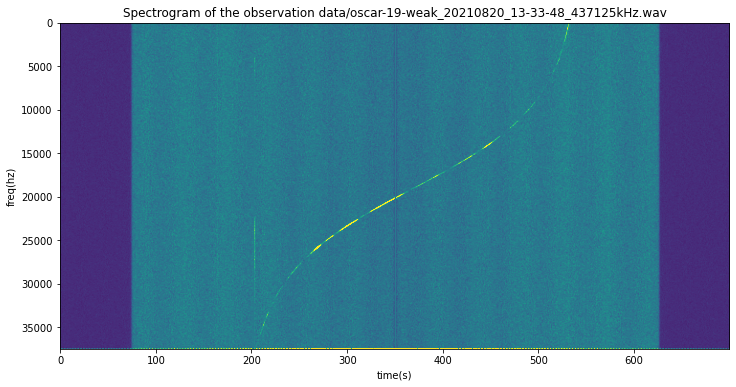

In [4]:

plt.figure(figsize=(12,6))
plt.imshow(array, cmap='viridis', aspect = 'auto', vmin=0, vmax=1000)
plt.xlabel('time(s)')
plt.ylabel('freq(hz)')
plt.title(f'Spectrogram of the observation {filename}')
plt.savefig('plots/spectrogram.png')
plt.show()

### Trying out the SoapCW package for a simple Viterbi implementation


In [10]:
import soapcw as soap

tr_1 = [np.log(1/3),np.log(1/3),np.log(1/3)]
one_tracks_ng = soap.single_detector(tr_1,array)

<ipython-input-10-3623b4e6fcef>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  one_tracks_ng = soap.single_detector(tr_1,array)


<ipython-input-11-9cf870d930a6>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  one_tracks_ng = soap.single_detector(tr_1,array)


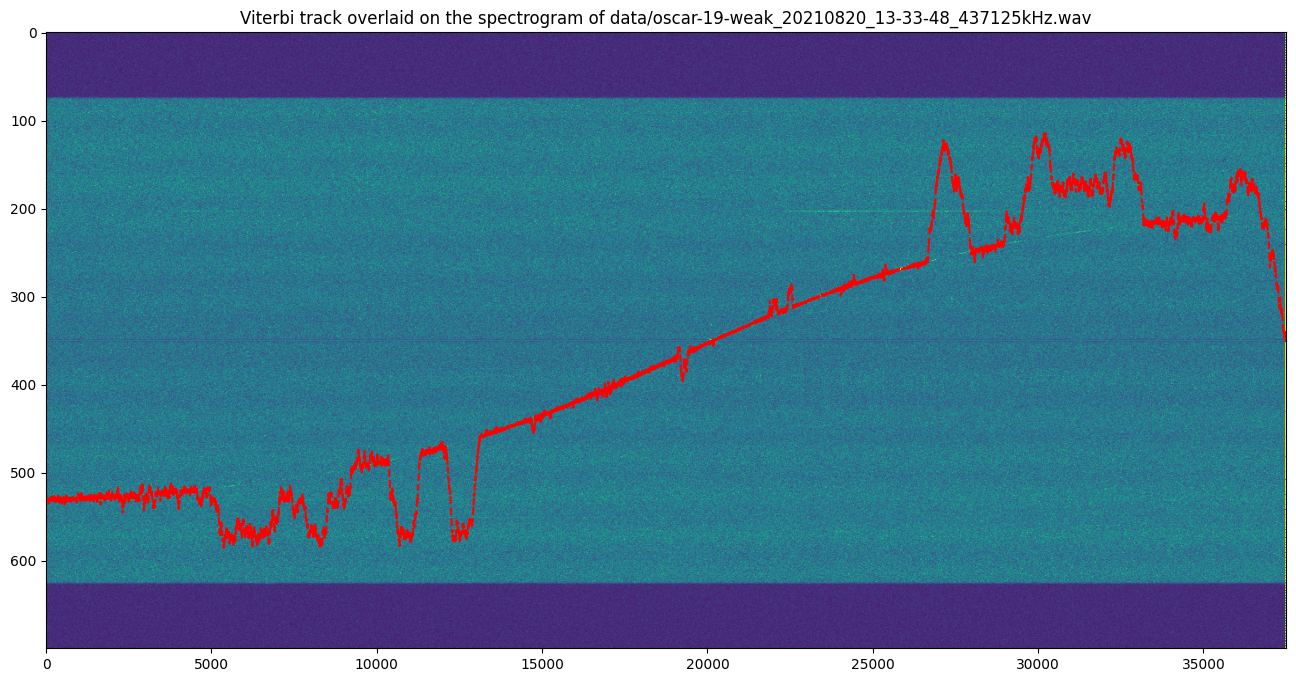

In [11]:
import soapcw as soap

tr_1 = [np.log(1/3),np.log(1/3),np.log(1/3)]
one_tracks_ng = soap.single_detector(tr_1,array)

vitmap = one_tracks_ng.vitmap
vit_line = one_tracks_ng.vit_track

plt.figure(figsize=(16,8))
plt.style.use('default')
plt.title(f'Viterbi track overlaid on the spectrogram of {filename}')
plt.imshow(np.flip(np.rot90(array, k=3),axis=1), aspect='auto',vmax=1000)
plt.plot(vit_line, c = 'r', ls='--', mew=1.5)
plt.savefig('plots/viterbi_track.png')

### Plotting the satellite tracks from TLEs

In [9]:
vit_line

array([531, 530, 531, ..., 350, 350, 350])

In [7]:
amateur = open('amateur.txt', 'r')
lines = amateur.readlines()

speed_of_light = 299792.458 # speed of light in km/s
ts = load.timescale()
sat = EarthSatellite(lines[1], lines[2], lines[0], ts)
observatory  = wgs84.latlon(55.90260773318829, -4.3077694373606460) # Acre Road
t = ts.utc(2021, 8, 18, 13, 40, np.linspace(0,1000))

pos = (sat - observatory).at(t)
_, _, the_range, _, _, range_rate = pos.frame_latlon_and_rates(observatory)
doppler = (1-range_rate.km_per_s/speed_of_light)

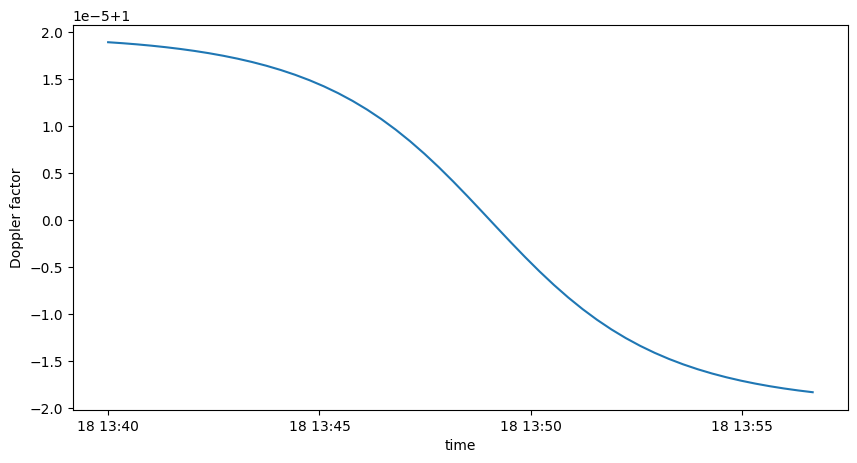

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(t.utc_datetime(), doppler)
plt.xlabel('time')
plt.ylabel('Doppler factor' )
plt.savefig('satellite_doppler_track.png')
plt.show()

The time-series needs to be divided into chunks of time. You can generate the power spectrum of each chunk and arrange these to form a time-frequency 2-D plot of the data. The Doppler track for that satellite can be generated form the amateur.txt file, which contains TLEs close to the observing times.  All being well, it you plot the computed Dopper track over the time-frequency data  they should match exactly.

### Some useful links
 - current satellite status https://www.amsat.org/status/
 - satellite passes (you can compute these with Skyfield) https://www.heavens-above.com/AmateurSats.aspx?lat=55.801&lng=-4.625&loc=Lochwinnoch&alt=51&tz=GMT
 - Transit-5B https://en.wikipedia.org/wiki/Zombie_satellite#Transit_5B-5
 - Oscar-19 https://www.n2yo.com/satellite/?s=20442